Capstone Project Notebook: Opening a Chinese restaurant in Toronto

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

from bs4 import BeautifulSoup
import requests

Get the borough/neighborhood info of Toronto

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'html.parser')

In [3]:
# define the dataframe columns
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

# instantiate the dataframe
Toronto_nbh = pd.DataFrame(columns=column_names)

In [4]:
for data in soup.find_all('tr'):
    data_1 = data.find('td')
#    print(data_1)
    if data_1 != None and data_1.string != None:
        if data_1.string[0] == 'M':
            postalcode = data_1.string
#            print(postalcode)
            
            data_2 = data_1.next_sibling.next_sibling
#            print(data_2)
            try:
                borough = data_2.find('a').text
#                print(borough)

                data_3 = data_2.next_sibling.next_sibling
#                print(data_3)
                try:
                    neighborhood = data_3.find('a').text
                except Exception as e:
                    neighborhood = borough  #If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
#                print(neighborhood)
            
                Toronto_nbh = Toronto_nbh.append({'PostalCode': postalcode,
                                                  'Borough': borough,
                                                  'Neighborhood': neighborhood}, ignore_index=True)
            
            except Exception as e:
                borough = data_2.string  #Ignore cells with a borough that is Not assigned.

In [5]:
Toronto_nbh.shape

(208, 3)

In [6]:
def nstrcat(arr):
    return ','.join(arr)

Toronto_nbh = Toronto_nbh.groupby(['PostalCode','Borough'], as_index=False).agg(nstrcat)

In [7]:
Toronto_nbh.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Scarborough,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Scarborough


Get the geographical coordinates of each postal code

In [8]:
df_coords = pd.read_csv('http://cocl.us/Geospatial_data/Geospatial_Coordinates.csv')
df_coords.shape

(103, 3)

Add the coordinates into the Toronto_nbh dataframe

In [9]:
Toronto_nbh = Toronto_nbh.join(df_coords.set_index('Postal Code'), on='PostalCode')

In [10]:
Toronto_nbh.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Scarborough,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Scarborough,43.773136,-79.239476


Let's work with only boroughs that contain the word Toronto

In [11]:
Toronto_data = Toronto_nbh[Toronto_nbh['Borough'].str.contains('Toronto')].reset_index(drop=True)
Toronto_data.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"East Toronto,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"East Toronto,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,East Toronto,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Central Toronto,43.712751,-79.390197
6,M4R,Central Toronto,Central Toronto,43.715383,-79.405678
7,M4S,Central Toronto,Central Toronto,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park,Central Toronto",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park,Central Toronto,Rathnelly,South Hill...",43.686412,-79.400049


In [12]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# use the inline backend to generate the plots within the browser
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

Search the venue info by neighborhood in Toronto city using the Forsquare API

In [13]:
CLIENT_ID = '4T3VZBFQEC0XGOZ0FIFSO4D2KBCMOE0OJ3NODZI4TQT32M2R' # your Foursquare ID
CLIENT_SECRET = 'HUDZRZPTU5TJPC20DKPAD5QFL4DQFEXYD4ZEUXP4IY3KVIMF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4T3VZBFQEC0XGOZ0FIFSO4D2KBCMOE0OJ3NODZI4TQT32M2R
CLIENT_SECRET:HUDZRZPTU5TJPC20DKPAD5QFL4DQFEXYD4ZEUXP4IY3KVIMF


In [14]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

def getNearbyVenues(postcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for code, lat, lng in zip(postcodes, latitudes, longitudes):
        print(code)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            code, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
Toronto_venues = getNearbyVenues(postcodes=Toronto_data['PostalCode'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

M4E
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6G
M6H
M6J
M6K
M6P
M6R
M6S
M7Y


In [16]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1707, 7)


,PostalCode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [17]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 238 uniques categories.


In [18]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
Toronto_onehot.shape

(1707, 238)

In [20]:
# Keep the venues only with Restaurant
for col in Toronto_onehot.columns:
    if ('Restaurant' not in col):
        Toronto_onehot = Toronto_onehot.drop(columns=col)


In [21]:
Toronto_onehot.head()

,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
Toronto_onehot.shape

(1707, 48)

In [23]:
# Make satistics the counts of different kinds of restaurants in each borough/neightborhood
Toronto_onehot['PostalCode'] = Toronto_venues['PostalCode']
Toronto_grouped = Toronto_onehot.groupby('PostalCode').sum().reset_index()
Toronto_grouped.head()

,PostalCode,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,...,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M4K,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,M4L,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,M4M,0,2,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
4,M4N,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# define the dataframe columns
column_names = ['PostalCode', 'Neighborhood', 'Chinese Restaurant', 'Total Number of Restaurants'] 

# instantiate the dataframe
Toronto_CH_Res = pd.DataFrame(columns=column_names)

Toronto_CH_Res[['PostalCode','Neighborhood']] = Toronto_data[['PostalCode','Neighborhood']]
Toronto_CH_Res['Chinese Restaurant'] = Toronto_grouped['Chinese Restaurant']
Toronto_CH_Res['Total Number of Restaurants'] = Toronto_grouped.sum(axis=1)

In [25]:
Toronto_CH_Res = Toronto_CH_Res.sort_values(by='Total Number of Restaurants', ascending=False).reset_index(drop=True)
Toronto_CH_Res

,PostalCode,Neighborhood,Chinese Restaurant,Total Number of Restaurants
0,M5T,"Chinatown,Grange Park,Kensington Market",5,35
1,M4Y,Church and Wellesley,1,29
2,M5X,"First Canadian Place,Underground city",0,27
3,M5L,"Commerce Court,Downtown Toronto",1,27
4,M5H,"Downtown Toronto,Downtown Toronto,Downtown Tor...",0,27
5,M5G,Downtown Toronto,2,25
6,M5C,St. James Town,0,25
7,M5B,"Downtown Toronto,Downtown Toronto",1,24
8,M5W,Downtown Toronto,0,22
9,M5K,"Design Exchange,Toronto Dominion Centre",1,22


Plot the number of restaurants by postal code

In [26]:
# step 1: get the data
df_number = Toronto_CH_Res[['PostalCode', 'Total Number of Restaurants']]
df_number.set_index('PostalCode', inplace=True)
#df_number.head()

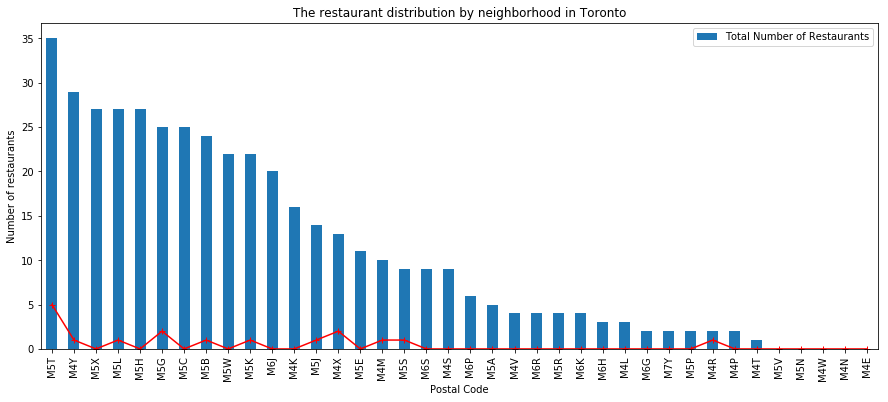

In [27]:
# plot data
fig = plt.figure()
ax1 = fig.gca()

df_number.plot(kind='bar', figsize=(15, 6), ax=ax1)

xc = Toronto_CH_Res['PostalCode']
yc = Toronto_CH_Res['Chinese Restaurant']
ax1.plot(xc, yc, color='red', marker='+', label='Number of Chinese Restaurant')

ax1.set_title ('The restaurant distribution by neighborhood in Toronto')
ax1.set_ylabel('Number of restaurants')
ax1.set_xlabel('Postal Code')

plt.show()


Find the most common restaurant in each neiborhood by postal code

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = Toronto_grouped['PostalCode']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,PostalCode,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,M4E,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
1,M4K,Greek Restaurant,Italian Restaurant,Caribbean Restaurant,Restaurant,Indian Restaurant
2,M4L,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant
3,M4M,American Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,Chinese Restaurant
4,M4N,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant


Use k-means clustering to separate the neighborhoods by number and style of restaurants

In [30]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on='PostalCode')

Toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
1,M4K,East Toronto,"East Toronto,Riverdale",43.679557,-79.352188,2,Greek Restaurant,Italian Restaurant,Caribbean Restaurant,Restaurant,Indian Restaurant
2,M4L,East Toronto,"East Toronto,India Bazaar",43.668999,-79.315572,0,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Doner Restaurant
3,M4M,East Toronto,East Toronto,43.659526,-79.340923,0,American Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,Chinese Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant
5,M4P,Central Toronto,Central Toronto,43.712751,-79.390197,0,Asian Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant
6,M4R,Central Toronto,Central Toronto,43.715383,-79.405678,0,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant
7,M4S,Central Toronto,Central Toronto,43.704324,-79.388790,0,Sushi Restaurant,Italian Restaurant,Indian Restaurant,Restaurant,Seafood Restaurant
8,M4T,Central Toronto,"Moore Park,Central Toronto",43.689574,-79.383160,0,Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant
9,M4V,Central Toronto,"Deer Park,Central Toronto,Rathnelly,South Hill...",43.686412,-79.400049,0,Vietnamese Restaurant,American Restaurant,Sushi Restaurant,Restaurant,Doner Restaurant


Creat map to show the segmenting and clusering of neighborhoods by the number and style of restaurants

In [32]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [34]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[0] + [1] + [2] + list(range(5, Toronto_merged.shape[1]))]]

,PostalCode,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
15,M5C,Downtown Toronto,St. James Town,1,Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant,Seafood Restaurant
18,M5H,Downtown Toronto,"Downtown Toronto,Downtown Toronto,Downtown Tor...",1,Thai Restaurant,American Restaurant,Asian Restaurant,Restaurant,Sushi Restaurant
20,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",1,Italian Restaurant,Restaurant,American Restaurant,Japanese Restaurant,Seafood Restaurant
21,M5L,Downtown Toronto,"Commerce Court,Downtown Toronto",1,Restaurant,American Restaurant,Seafood Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
28,M5W,Downtown Toronto,Downtown Toronto,1,Restaurant,Fast Food Restaurant,Seafood Restaurant,Italian Restaurant,Japanese Restaurant
29,M5X,Downtown Toronto,"First Canadian Place,Underground city",1,Restaurant,American Restaurant,Asian Restaurant,Seafood Restaurant,Thai Restaurant


In [35]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[0] + [1] + [2] + list(range(5, Toronto_merged.shape[1]))]]

,PostalCode,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
11,M4X,Downtown Toronto,"Cabbagetown,St. James Town",4,Restaurant,Italian Restaurant,Chinese Restaurant,Indian Restaurant,American Restaurant
12,M4Y,Downtown Toronto,Church and Wellesley,4,Japanese Restaurant,Sushi Restaurant,Restaurant,Fast Food Restaurant,Mediterranean Restaurant
14,M5B,Downtown Toronto,"Downtown Toronto,Downtown Toronto",4,Fast Food Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Italian Restaurant,Japanese Restaurant
17,M5G,Downtown Toronto,Downtown Toronto,4,Italian Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant
19,M5J,Downtown Toronto,"Downtown Toronto,Toronto Islands,Union Station",4,Italian Restaurant,Restaurant,Indian Restaurant,Japanese Restaurant,New American Restaurant
